In [ ]:
!pip install autots


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.9/974.9 kB 10.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from autots import AutoTS
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_doge_raw = pd.read_excel(r"/content/dogecoin-20250312122652871.xlsx",engine='openpyxl')

In [ ]:
df_doge_raw['date'] = pd.to_datetime(df_doge_raw['timeOpen'], unit='ms')
df = df_doge_raw.sort_values('date')  # Ensure chronological order
df.set_index('date', inplace=True)

In [ ]:
df_doge_raw.head()

,timeOpen,timeClose,timeHigh,timeLow,priceOpen,priceHigh,priceLow,priceClose,volume,date
0,1741521600000,1741607999999,1741525680000,1741587900000,0.192171,0.193997,0.166287,0.167803,1.797791e+09,2025-03-09 12:00:00
1,1741435200000,1741521599999,1741439400000,1741497180000,0.197973,0.200669,0.191506,0.192172,9.499464e+08,2025-03-08 12:00:00
2,1741348800000,1741435199999,1741402140000,1741352160000,0.201727,0.208331,0.191547,0.197973,1.829179e+09,2025-03-07 12:00:00
3,1741262400000,1741348799999,1741282980000,1741332840000,0.204719,0.219231,0.199566,0.201727,1.799078e+09,2025-03-06 12:00:00
4,1741176000000,1741262399999,1741214280000,1741192260000,0.199143,0.205957,0.196583,0.204720,1.433657e+09,2025-03-05 12:00:00


In [ ]:
df2 = df_doge_raw.copy()

In [ ]:
print(f'We have {df2.shape[0]} rows and {df2.shape[1]} columns in our dataset')

We have 362 rows and 10 columns in our dataset


In [ ]:
df2.dtypes


,0
timeOpen,int64
timeClose,int64
timeHigh,int64
timeLow,int64
priceOpen,float64
priceHigh,float64
priceLow,float64
priceClose,float64
volume,float64
date,datetime64[ns]


In [ ]:
df2.describe()


,timeOpen,timeClose,timeHigh,timeLow,priceOpen,priceHigh,priceLow,priceClose,volume,date
count,3.620000e+02,3.620000e+02,3.620000e+02,3.620000e+02,362.000000,362.000000,362.000000,362.000000,3.620000e+02,362
mean,1.725926e+12,1.726013e+12,1.725966e+12,1.725968e+12,0.199016,0.206909,0.189922,0.198624,2.765612e+09,2024-09-10 00:00:00
min,1.710331e+12,1.710418e+12,1.710359e+12,1.710386e+12,0.000000,0.000000,0.000000,0.000000,2.853912e+08,2024-03-13 12:00:00
25%,1.718129e+12,1.718215e+12,1.718147e+12,1.718178e+12,0.121914,0.125327,0.116210,0.121917,7.532762e+08,2024-06-11 18:00:00
50%,1.725926e+12,1.726013e+12,1.725975e+12,1.725954e+12,0.156438,0.162123,0.148340,0.156438,1.454566e+09,2024-09-10 00:00:00
75%,1.733724e+12,1.733810e+12,1.733728e+12,1.733790e+12,0.263719,0.268896,0.250204,0.261406,2.939360e+09,2024-12-09 06:00:00
max,1.741522e+12,1.741608e+12,1.741526e+12,1.741588e+12,0.467299,0.483510,0.448240,0.467297,3.993647e+10,2025-03-09 12:00:00
std,9.041297e+09,9.041297e+09,9.041413e+09,9.042758e+09,0.104101,0.109491,0.099376,0.103820,3.919651e+09,NaN


In [ ]:
df2.isnull().sum()


,0
timeOpen,0
timeClose,0
timeHigh,0
timeLow,0
priceOpen,0
priceHigh,0
priceLow,0
priceClose,0
volume,0
date,0


In [ ]:
df2['volume'] = df2['volume'].fillna(0)

In [ ]:
df2.isnull().sum()
df2

,timeOpen,timeClose,timeHigh,timeLow,priceOpen,priceHigh,priceLow,priceClose,volume,date
0,1741521600000,1741607999999,1741525680000,1741587900000,0.192171,0.193997,0.166287,0.167803,1.797791e+09,2025-03-09 12:00:00
1,1741435200000,1741521599999,1741439400000,1741497180000,0.197973,0.200669,0.191506,0.192172,9.499464e+08,2025-03-08 12:00:00
2,1741348800000,1741435199999,1741402140000,1741352160000,0.201727,0.208331,0.191547,0.197973,1.829179e+09,2025-03-07 12:00:00
3,1741262400000,1741348799999,1741282980000,1741332840000,0.204719,0.219231,0.199566,0.201727,1.799078e+09,2025-03-06 12:00:00
4,1741176000000,1741262399999,1741214280000,1741192260000,0.199143,0.205957,0.196583,0.204720,1.433657e+09,2025-03-05 12:00:00
...,...,...,...,...,...,...,...,...,...,...
357,1710676800000,1710763199999,1710740940000,1710703500000,0.142364,0.158761,0.137732,0.154330,2.329294e+09,2024-03-17 12:00:00
358,1710590400000,1710676799999,1710596040000,1710674340000,0.163231,0.164936,0.138419,0.142368,2.400392e+09,2024-03-16 12:00:00
359,1710504000000,1710590399999,1710508560000,1710537300000,0.177329,0.181057,0.154082,0.163231,3.584307e+09,2024-03-15 12:00:00
360,1710417600000,1710503999999,1710432840000,1710423780000,0.169158,0.191512,0.165624,0.177330,6.047717e+09,2024-03-14 12:00:00


In [ ]:
df = df.replace(0, np.nan)  # Replace 0 with NaN
df = df.fillna(method='ffill')

In [ ]:
features = ['priceOpen', 'priceHigh', 'priceLow', 'priceClose', 'volume']
data = df[features]

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [ ]:
df3 = df2.copy()


In [ ]:
df['Date'] = pd.to_datetime(df['timeOpen'], unit='ms')

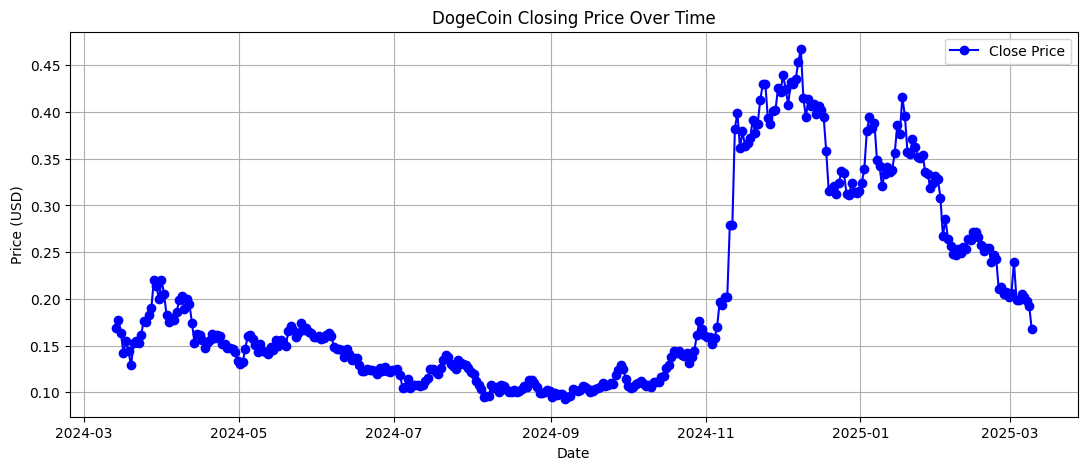

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(df['Date'], df['priceClose'], label='Close Price', color='blue', marker='o')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title('DogeCoin Closing Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df['Daily Change %'] = df['priceClose'].pct_change() * 100

In [ ]:
df['Rolling Volatility'] = df['Daily Change %'].rolling(window=30).std()


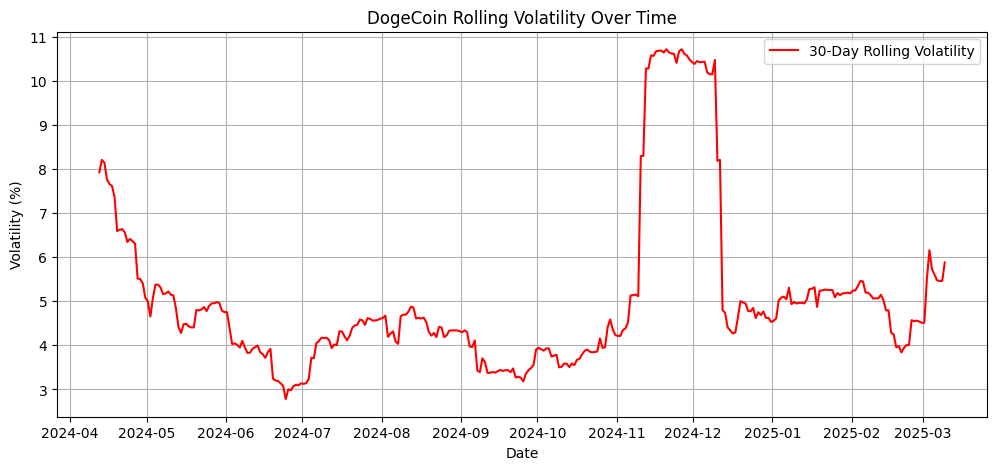

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Rolling Volatility'], label='30-Day Rolling Volatility', color='red')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.title('DogeCoin Rolling Volatility Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
correlation_matrix = df[['priceOpen', 'priceClose', 'priceHigh', 'priceLow']].corr()


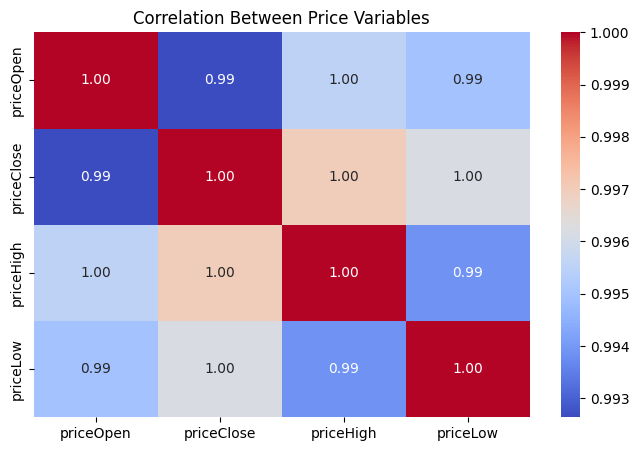

In [ ]:
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Price Variables")
plt.show()


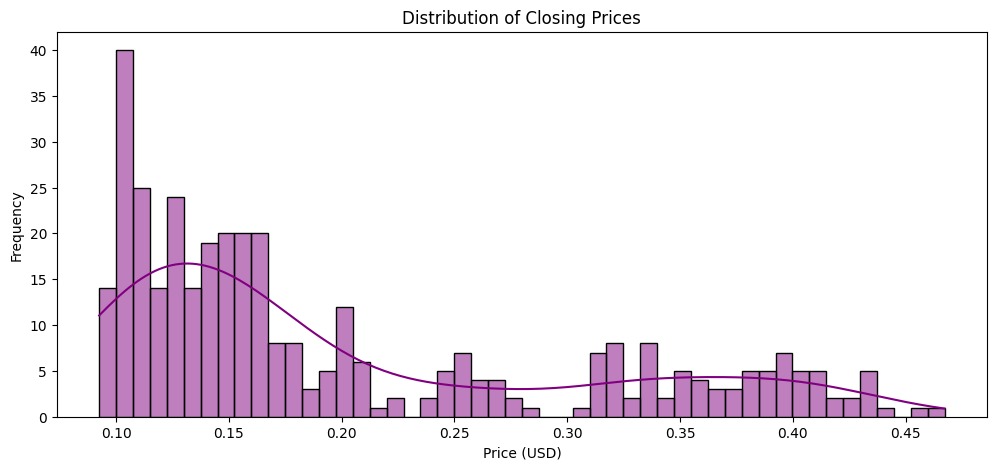

In [ ]:
plt.figure(figsize=(12, 5))
sns.histplot(df['priceClose'], bins=50, kde=True, color='purple')
plt.xlabel('Price (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Closing Prices')
plt.show()


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
df['Year-Month'] = pd.to_datetime(df['timeOpen'], unit='ms').dt.to_period('M')

# Calculate monthly average closing price
monthly_avg = df.groupby('Year-Month')['priceClose'].mean().reset_index()



In [ ]:
monthly_avg['Year-Month'] = monthly_avg['Year-Month'].astype(str)


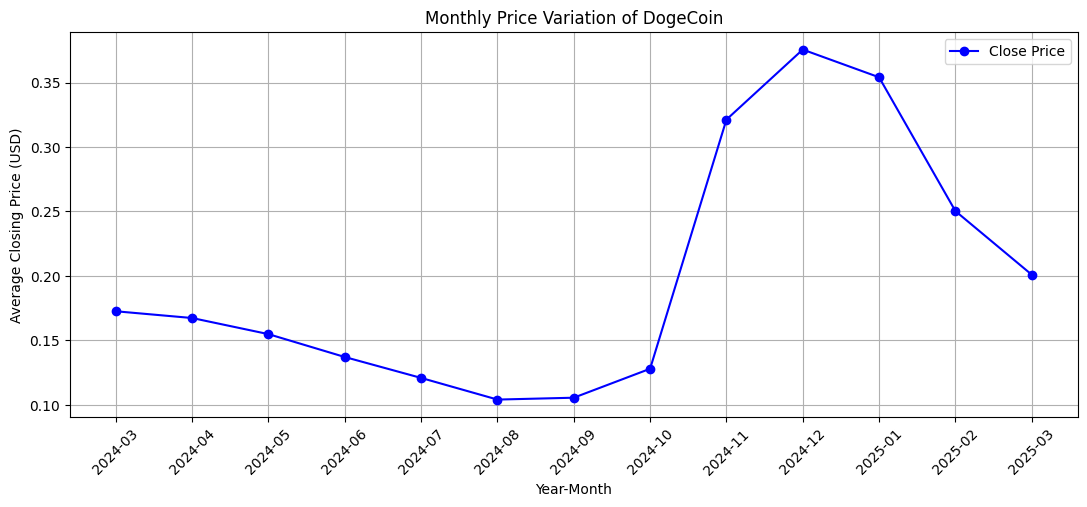

In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(monthly_avg['Year-Month'].astype(str), monthly_avg['priceClose'], label='Close Price', color='blue', marker='o')
plt.xlabel('Year-Month')
plt.ylabel('Average Closing Price (USD)')
plt.title('Monthly Price Variation of DogeCoin')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 3])  # Predict priceClose (index 3)
    return np.array(X), np.array(y)

In [ ]:
seq_length = 10  # Use 10 days of history
X, y = create_sequences(scaled_data, seq_length)

In [ ]:
# Split into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))  # Output layer for priceClose
model.compile(optimizer='adam', loss='mse')



In [ ]:
# Train the model

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0293 - val_loss: 0.0701
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0123 - val_loss: 0.0087
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0071 - val_loss: 0.0101
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0058 - val_loss: 0.0643
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0075 - val_loss: 0.0080
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0035 - val_loss: 0.0123
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0046 - val_loss: 0.0123
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0036 - val_loss: 0.0097
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0049 - val_loss: 0.0117
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0047 - val_loss: 0.0087
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0038 - val_loss: 0.0059
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0059 - val_loss: 0.0104
E

In [ ]:
model.save("lstm_model.h5")  # Saves to HDF5 format
print("Model saved as 'lstm_model.h5'")

Model saved as 'lstm_model.h5'


In [ ]:
# Evaluate the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
# Inverse transform predictions (only priceClose column)
scaler_price = MinMaxScaler()
scaler_price.fit(data[['priceClose']])
train_predict = scaler_price.inverse_transform(train_predict)
test_predict = scaler_price.inverse_transform(test_predict)
y_train_inv = scaler_price.inverse_transform([y_train])
y_test_inv = scaler_price.inverse_transform([y_test])

In [ ]:
# Calculate evaluation metrics
train_mse = mean_squared_error(y_train_inv[0], train_predict[:, 0])
test_mse = mean_squared_error(y_test_inv[0], test_predict[:, 0])
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train_inv[0], train_predict[:, 0])
test_mae = mean_absolute_error(y_test_inv[0], test_predict[:, 0])
train_r2 = r2_score(y_train_inv[0], train_predict[:, 0])
test_r2 = r2_score(y_test_inv[0], test_predict[:, 0])

In [ ]:
# Print all metrics
print("\nModel Performance Metrics:")
print(f"Train MSE: {train_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")
print(f"Train RMSE: ${train_rmse:.6f}")
print(f"Test RMSE: ${test_rmse:.6f}")
print(f"Train MAE: ${train_mae:.6f}")
print(f"Test MAE: ${test_mae:.6f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")


Model Performance Metrics:
Train MSE: 0.000365
Test MSE: 0.001379
Train RMSE: $0.019095
Test RMSE: $0.037129
Train MAE: $0.011707
Test MAE: $0.027193
Train R²: 0.9631
Test R²: 0.6536


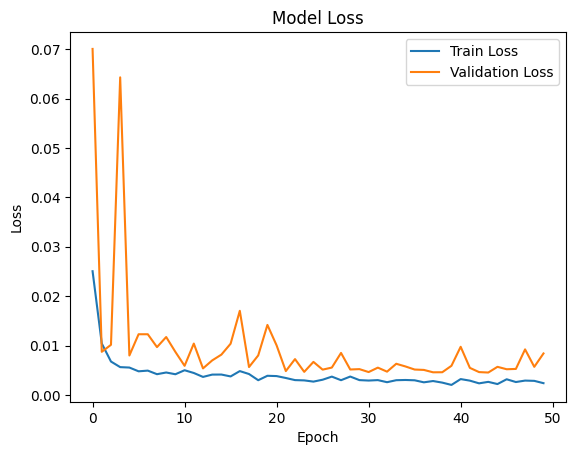

In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

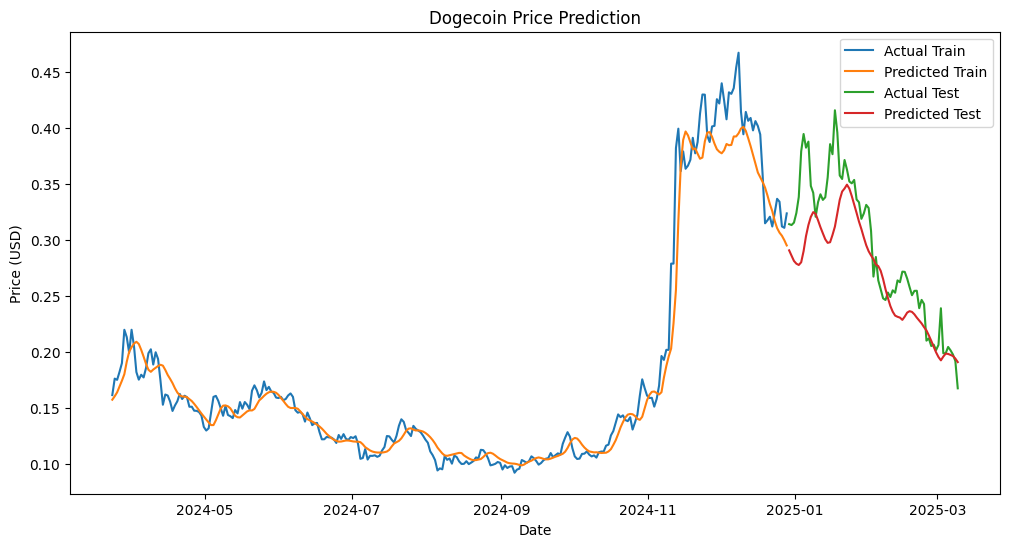

In [ ]:
# Plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(df.index[seq_length:train_size + seq_length], y_train_inv[0], label='Actual Train')
plt.plot(df.index[seq_length:train_size + seq_length], train_predict[:, 0], label='Predicted Train')
plt.plot(df.index[train_size + seq_length:], y_test_inv[0], label='Actual Test')
plt.plot(df.index[train_size + seq_length:], test_predict[:, 0], label='Predicted Test')
plt.title('Dogecoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
# Predict the next day's price
last_sequence = scaled_data[-seq_length:]
last_sequence = last_sequence.reshape((1, seq_length, len(features)))
next_price_scaled = model.predict(last_sequence)
next_price = scaler_price.inverse_transform(next_price_scaled)
print(f'Predicted Dogecoin price for next day: ${next_price[0][0]:.6f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Dogecoin price for next day: $0.186240


In [ ]:
threshold = 0.05  # 5% change threshold
signals = []
for i in range(len(test_predict)):
    actual_today = y_test_inv[0][i] if i == 0 else y_test_inv[0][i-1]
    predicted_tomorrow = test_predict[i, 0]
    pct_change = (predicted_tomorrow - actual_today) / actual_today
    if pct_change > threshold:
        signals.append('Buy')
    elif pct_change < -threshold:
        signals.append('Sell')
    else:
        signals.append('Hold')

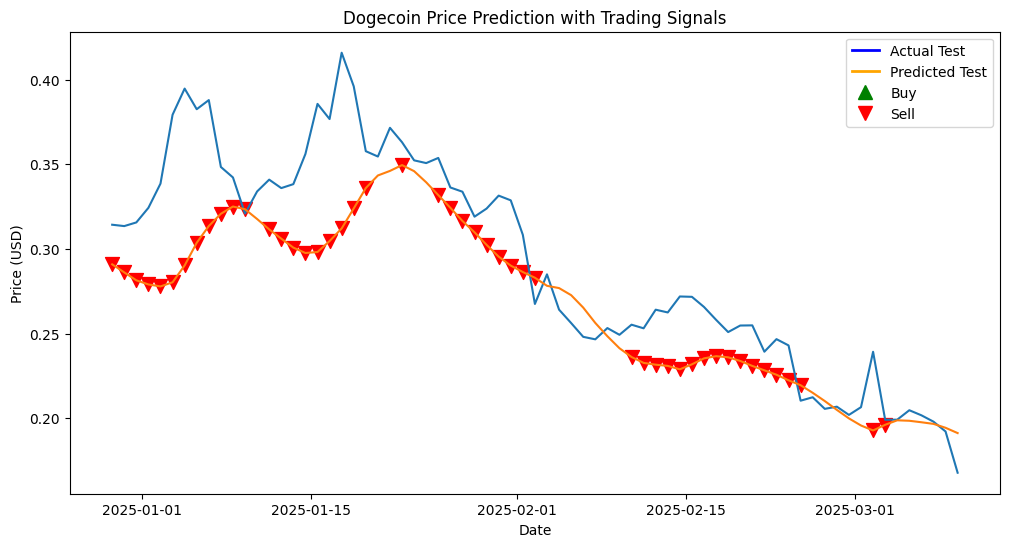

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(12, 6))
actual_line = plt.plot(df.index[train_size + seq_length:], y_test_inv[0], label='Actual Test')
predict_line = plt.plot(df.index[train_size + seq_length:], test_predict[:, 0], label='Predicted Test')

# Plot Buy and Sell signals
for i, signal in enumerate(signals):
    if signal == 'Buy':
        plt.scatter(df.index[train_size + seq_length + i], test_predict[i, 0], color='green', marker='^', s=100)
    elif signal == 'Sell':
        plt.scatter(df.index[train_size + seq_length + i], test_predict[i, 0], color='red', marker='v', s=100)

# Custom legend handles
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Actual Test'),
    Line2D([0], [0], color='orange', lw=2, label='Predicted Test'),
    Line2D([0], [0], marker='^', color='green', linestyle='None', markersize=10, label='Buy'),
    Line2D([0], [0], marker='v', color='red', linestyle='None', markersize=10, label='Sell')
]

plt.title('Dogecoin Price Prediction with Trading Signals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(handles=legend_elements)
plt.show()

In [ ]:
# Print next-day signal
last_actual = df['priceClose'].iloc[-1]
next_pct_change = (next_price[0][0] - last_actual) / last_actual
next_signal = 'Buy' if next_pct_change > threshold else 'Sell' if next_pct_change < -threshold else 'Hold'
print(f'Next day signal: {next_signal}')

Next day signal: Buy
